In [1]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime

def resampleData(data, period='1H'):
    data['time'] = pd.Index(map(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S") , data_excel['time']))
    data_time = data.set_index('time').dropna()
    dataResample = data_time.resample(period).agg({'high':'max','open':'first','close':'last','low':'min','volume':'sum','amount':'sum'}).dropna()
    return dataResample

data_excel = pd.read_csv(r'E:\2018_Course\AnalysisTool\HFD\bch_usdt.csv').iloc[:,1:]
data1H = resampleData(data_excel, period='1H')

In [7]:
def initDv(data):
    data['time'] = data.index
    data["trade_date"] = data["time"].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    data["symbol"] = "btc_usdt"
    data['usdt'] = 6.8
    data = data.set_index(["trade_date","symbol"])
    dv.create_init_dv(data) # 用来初始化dv
dataDv = data1H.copy()
initDv(dataDv)

Initialize dataview success.


In [8]:
vwap = dv.add_formula('vwap_c','amount/(volume*usdt)', add_data=True)

In [15]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

## 画图观察数据Alpha(1-10)
### ahplha1: (rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) -0.5)

In [16]:
def RankPct(df):
    return df.rank(axis=1, pct=True)

In [17]:
alpha1=dv.add_formula('alpha1_C','RankPct(Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5))',add_data=True, register_funcs={'RankPct':RankPct})

Field [alpha1_C] is overwritten.


In [18]:
alpha1_change = dv.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True, register_funcs={'RankPct':RankPct})

Field [alpha1_C] is overwritten.


In [19]:
alpha1_plot = dv.get_ts('alpha1_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

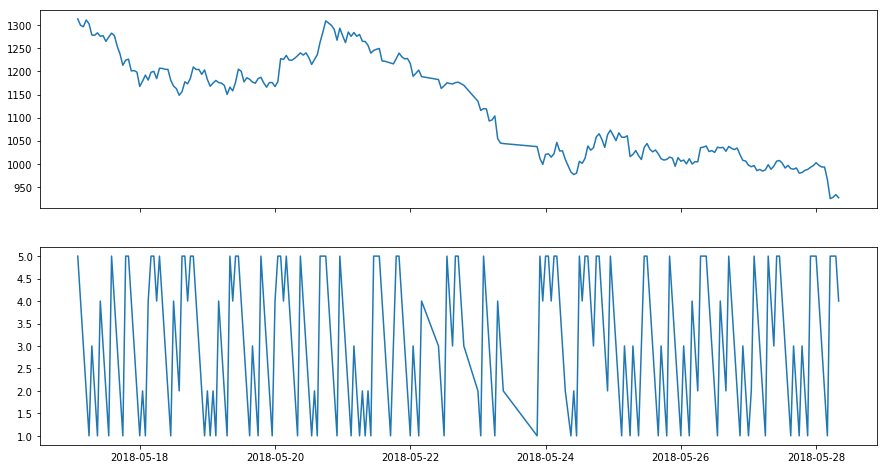

In [20]:
plot_chart(close, alpha1_plot)

### alpha002:(-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))

In [10]:
# alpha2=dv.add_formula('alpha2_C','-1*Correlation(RankPct(Delta(Log(volume),2)),RankPct(((close-open)/open)),6)',add_data=True, register_funcs={'RankPct':RankPct})

In [21]:
alpha2_change = dv.add_formula('alpha2_C','-1*Correlation(Delta(Log(volume),2),((close-open)/open),6)',add_data=True, register_funcs={'RankPct':RankPct})

In [22]:
alpha2_plot = dv.get_ts('alpha2_C',date_type='datetime')

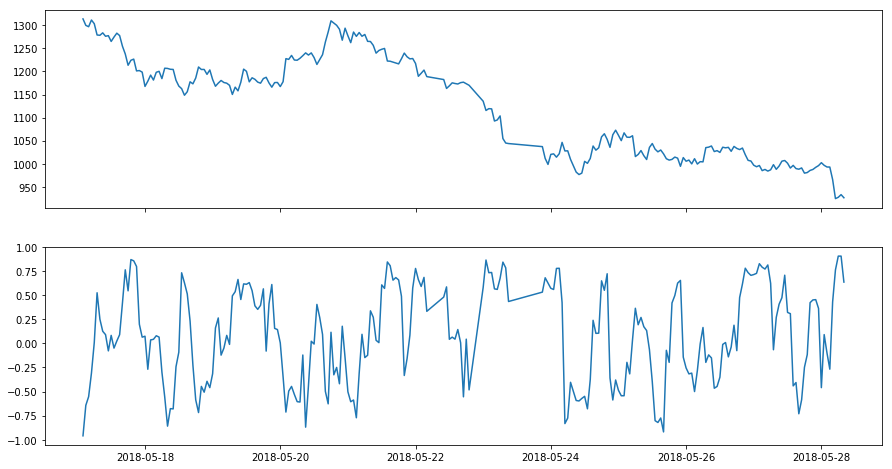

In [23]:
plot_chart(close, alpha2_plot)

### alpha003: (-1 * correlation(rank(open), rank(volume), 10))

In [24]:
alpha3=dv.add_formula('alpha3_C','-1*Correlation(RankPct(open), Rank(volume),10)',add_data=True, register_funcs={'RankPct':RankPct})

### alpha004: (-1 * Ts_Rank(rank(low), 9))

In [25]:
alpha4=dv.add_formula('alpha4_C','-1*Ts_Rank(RankPct(low),9)',add_data=True,register_funcs={'RankPct':RankPct})

In [26]:
alpha4_change=dv.add_formula('alpha4_C','Ts_Rank(low,9)',add_data=True,register_funcs={'RankPct':RankPct})

Field [alpha4_C] is overwritten.


In [27]:
alpha4_plot = dv.get_ts('alpha4_C', date_type='datetime')

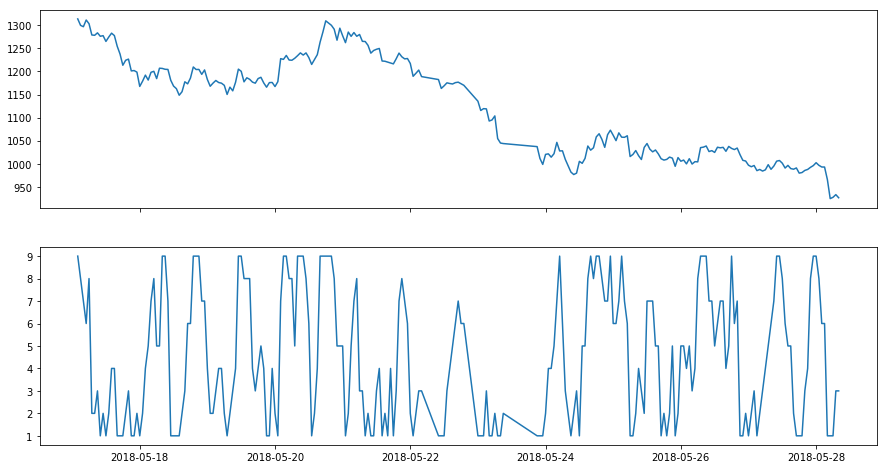

In [28]:
plot_chart(close, alpha4_plot)

### alpha5: (rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))

In [35]:
# alpha5=dv.add_formula('alpha5_C','RankPct((open-(Ts_Sum(vwap_c,10)/10)))*(-1*Abs(RankPct(close-vwap_c)))',add_data=True,register_funcs={'RankPct':RankPct})

In [29]:
alpha5_change=dv.add_formula('alpha5_C','open-(Ts_Sum(vwap_c,10)/10)*(-1*Abs(close-vwap_c))',add_data=True,register_funcs={'RankPct':RankPct})

In [30]:
alpha5_plot = dv.get_ts('alpha5_C', date_type='datetime')

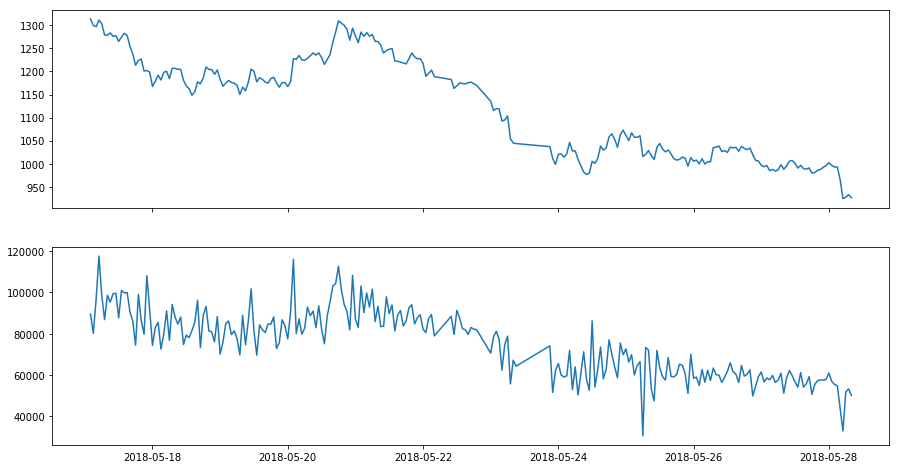

In [31]:
plot_chart(close, alpha5_plot)

### alpha006: (-1 * correlation(open, volume, 10))

In [32]:
alpha6=dv.add_formula(field_name='alpha6_C',formula='-1*Correlation(open,volume,10)',add_data=True)

In [33]:
alpha6_plot = dv.get_ts('alpha6_C', date_type='datetime')

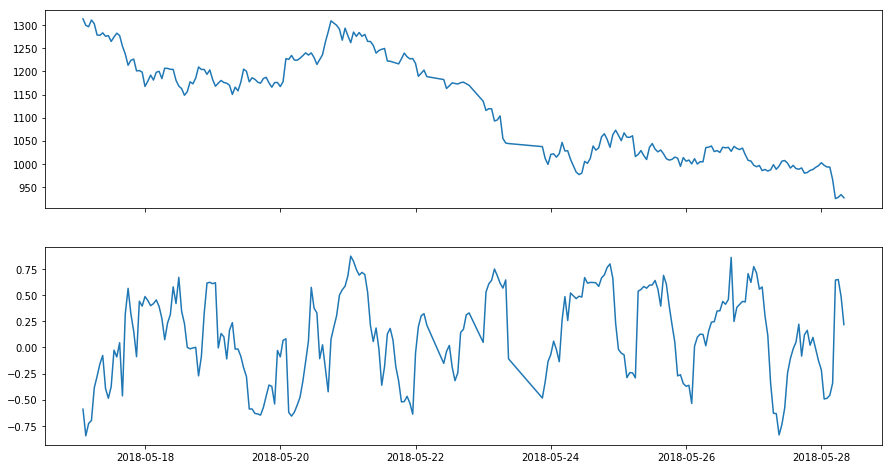

In [34]:
plot_chart(close, alpha6_plot)

### alpha007: ((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1* 1))

In [38]:
alpha7=dv.add_formula('alpha7_C','-1*If(Ts_Mean(volume,20)<volume, (-1*Ts_Rank(Abs(Delta(close,7)),60))*Sign(Delta(close,7)),-1)',add_data=True)

Field [alpha7_C] is overwritten.


In [39]:
alpha7_plot = dv.get_ts('alpha7_C', date_type='datetime')

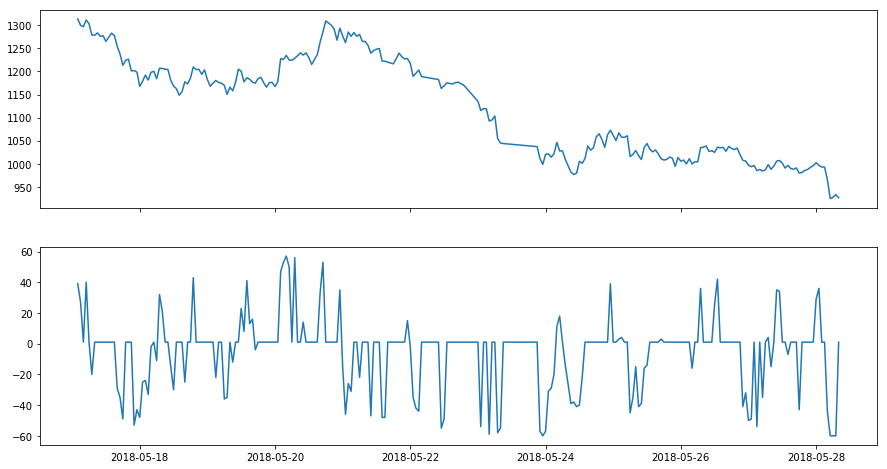

In [40]:
plot_chart(close, alpha7_plot)

### alpha8: (-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)),10))))

In [16]:
# alpha8 = dv.add_formula('alpha8_C','-1*RankPct(((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10)))',add_data=True,register_funcs={'RankPct':RankPct})

In [41]:
alpha8_change = dv.add_formula('alpha8_C','-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))',add_data=True,register_funcs={'RankPct':RankPct})

In [42]:
alpha8_plot = dv.get_ts('alpha8_C', date_type='datetime')

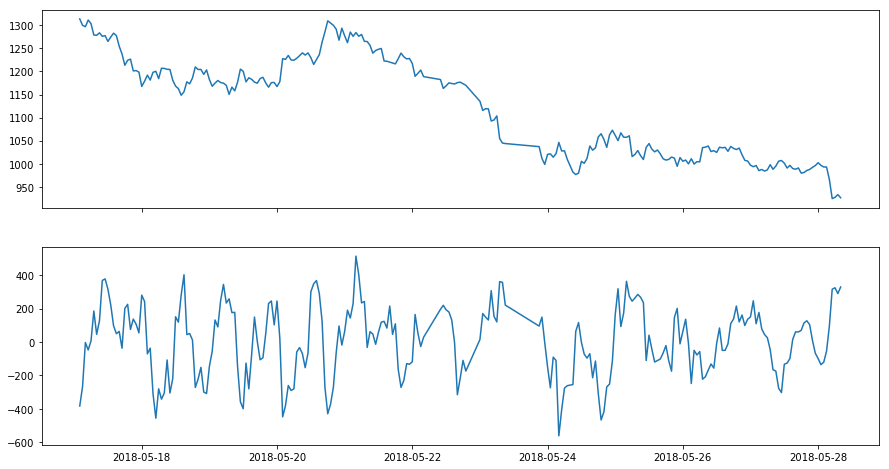

In [43]:
plot_chart(close, alpha8_plot)

### alpha009:((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ?delta(close, 1) : (-1 * delta(close, 1))))

In [44]:
alpha9 = dv.add_formula('alpha9_C','If(Ts_Min(Delta(close,1),5)>0,Delta(close,1),If((Ts_Max(Delta(close,1),5)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [45]:
alpha9_plot = dv.get_ts('alpha9_C', date_type='datetime')

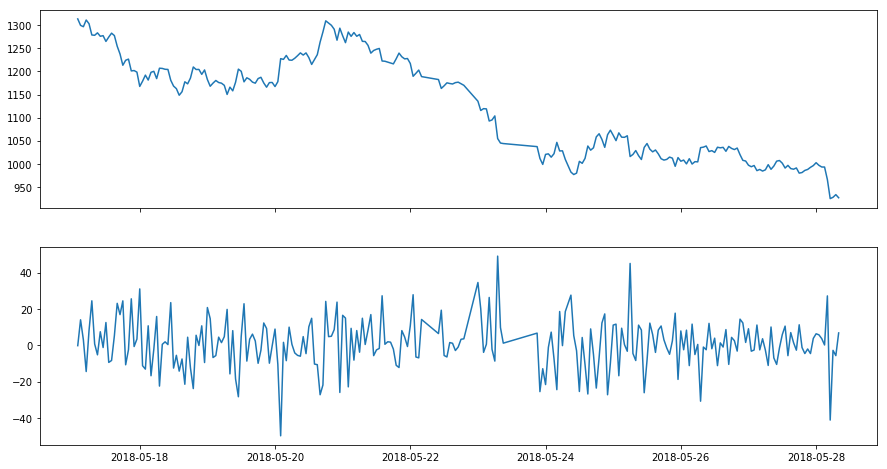

In [46]:
plot_chart(close, alpha9_plot)

### alpha010: rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0)? delta(close, 1) : (-1 * delta(close, 1)))))

In [47]:
alpha10 = dv.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [48]:
alpha10_plot = dv.get_ts('alpha10_C', date_type='datetime')

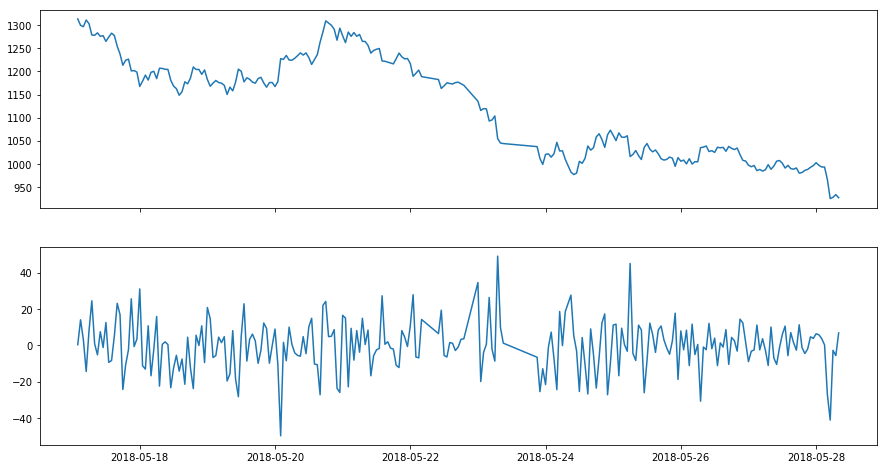

In [49]:
plot_chart(close, alpha10_plot)

### alpha11: ((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3)))*rank(delta(volume, 3)))

In [19]:
alpha11 = dv.add_formula('alpha11_C','RankPct(Ts_Max((vwap_c-close),3))+RankPct(Ts_Min((vwap_c-close),3))*RankPct(Delta(volume,3))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha012:(sign(delta(volume, 1)) * (-1 * delta(close, 1)))

In [20]:
alpha12 = dv.add_formula('alpha12_C','Sign(Delta(volume,1)*(-1*Delta(close,1)))',add_data=True)

### alpha013:(-1 * rank(covariance(rank(close), rank(volume), 5)))

In [21]:
alpha13 = dv.add_formula('alpha13_C','-1*RankPct(Covariance(RankPct(close),RankPct(volume),5))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha014:((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))

In [22]:
alpha14 = dv.add_formula('alpha14_C','-1*RankPct(Delta(Return(close,1),3)*Correlation(open, volume,10))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha015:(-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3))

In [23]:
alpha15 = dv.add_formula('alpha15_C','Ts_Sum(RankPct(Correlation(RankPct(high),RankPct(volume),3)),3)',add_data=True,register_funcs={'RankPct':RankPct})

### alpha016:(-1 * rank(covariance(rank(high), rank(volume), 5)))

In [24]:
alpha16 = dv.add_formula('alpha16_C','-1*RankPct(Covariance(RankPct(high),RankPct(volume),5))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha017: (((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) *rank(ts_rank((volume / adv20), 5)))

In [25]:
alpha17 = dv.add_formula('alpha16_C','-1*RankPct(Covariance(RankPct(high),RankPct(volume),5))',add_data=False,register_funcs={'RankPct':RankPct})

### alpha018: (-1 * rank(((stddev(abs((close - open)), 5) + (close - open)) + correlation(close, open,10))))

In [26]:
alpha18 = dv.add_formula('alpha18_C','-1*RankPct(((StdDev(Abs(close-open),5)+(close-open))+Correlation(close,open,10)))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha019:((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + sum(returns,250)))))

In [27]:
alpha19 = dv.add_formula('alpha19_C','((-1*Sign(((close-Delay(close,7))+Delta(close,7))))*(1+RankPct((1+Ts_Sum(Return(close,1),250)))))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha020: (((-1 * rank((open - delay(high, 1))))  * rank((open - delay(close, 1)))) * rank((open -delay(low, 1))))

In [28]:
alpha20 = dv.add_formula('alpha20_C','-1*RankPct((open-Delay(high,1)))*RankPct((open-Delay(close,1)))*RankPct((open-Delay(low,1)))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha021: ((((sum(close, 8) / 8) + stddev(close, 8)) < (sum(close, 2) / 2)) ? (-1 * 1) : (((sum(close,2) / 2) < ((sum(close, 8) / 8) - stddev(close, 8))) ? 1 : (((1 < (volume / adv20)) || ((volume /adv20) == 1)) ? 1 : (-1 * 1))))

In [29]:
alpha21 = dv.add_formula('alpha21_C','If(((Ts_Sum(close,8)/8)+StdDev(close,8))<(Ts_Sum(close,2)/2),-1,If(Ts_Sum(close,2)<(Ts_Sum(close,8)-StdDev(close,8)),1,If((volume/Ts_Mean(volume,20))>=1,1,-1)))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha022:(-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20))))

In [30]:
alpha22 = dv.add_formula('alpha22_C','-1*(Delta(Correlation(high,volume,5),5)*RankPct(StdDev(close,20)))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha023: (((sum(high, 20) / 20) < high) ? (-1 * delta(high, 2)) : 0)

In [31]:
alpha23 = dv.add_formula('alpha23_C','If(Ts_Sum(high,20)/20<high,-1*Delta(high,2),0)',add_data=True,register_funcs={'RankPct':RankPct})

### alpha024: ((((delta((sum(close, 100) / 100), 100) / delay(close, 100)) < 0.05) ||((delta((sum(close, 100) / 100), 100) / delay(close, 100)) == 0.05)) ? (-1 * (close - ts_min(close,100))) : (-1 * delta(close, 3)))


In [32]:
alpha24 = dv.add_formula('alpha24_C','If(Delta(Ts_Sum(close,100)/100,100)/Delay(close,100)<=0.05,-1*(close-Ts_Min(close,100)),-1*Delta(close,3))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha25: rank(((((-1 * returns) * adv20) * vwap) * (high - close)))

In [33]:
alpha25 = dv.add_formula('alpha25_C','RankPct(-1*Return(close,1)*Ts_Mean(volume,20)*vwap_c*(high-close))',add_data=True,register_funcs={'RankPct':RankPct})

### alpha026:(-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))

In [34]:
alpha26 = dv.add_formula('alpha26_C','-1*Ts_Max(Correlation(Ts_Rank(volume,5),Ts_Rank(high,5),5),3)',add_data=True,register_funcs={'RankPct':RankPct})

### alpha27: ((0.5 < rank((sum(correlation(rank(volume), rank(vwap), 6), 2) / 2.0))) ? (-1 * 1) : 1)

In [35]:
alpha27 = dv.add_formula('alpha27_C','If(RankPct((Ts_Sum(Correlation(RankPct(volume), RankPct(vwap_c),6),2)/2)),-1,1)',add_data=False,register_funcs={'RankPct':RankPct})

### alpha028:scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))

In [138]:
def Scale(df,k=1):
    return df.mul(k).div(np.abs(df).sum())

alpha28 = dv.add_formula('alpha28_C','Scale(Correlation(Ts_Mean(volume,20),low,5)+((high+low)/2)-close)',add_data=False,register_funcs={'Scale':Scale})

### alpha029: min(product(rank(rank(scale(log(sum(ts_min(rank(rank((-1 * rank(delta((close - 1),5))))), 2), 1))))), 1), 5) + ts_rank(delay((-1 * returns), 6), 5)

In [40]:
alpha29 = dv.add_formula('alpha29_C','Ts_Min(Ts_Product(RankPct(RankPct(Scale(Log(Ts_Sum(Ts_Min(RankPct(RankPct((-1*RankPct(Delta((close-1),5))))),2),1))))),1),5)+Ts_Rank(Delay((-1*Return(close,1)),6),5)',add_data=True,register_funcs={'RankPct':RankPct,'Scale':Scale})

### alpha030:(((1.0 - rank(((sign((close - delay(close, 1))) + sign((delay(close, 1) - delay(close, 2)))) +sign((delay(close, 2) - delay(close, 3)))))) * sum(volume, 5)) / sum(volume, 20))

In [44]:
alpha30 = dv.add_formula('alpha30_C','(((1-RankPct(((Sign((close-Delay(close,1)))+Sign((Delay(close,1)-Delay(close,2))))+Sign((Delay(close,2)-Delay(close,3))))))*Ts_Sum(volume,5))/Ts_Sum(volume,20))',add_data=True, register_funcs={'RankPct':RankPct})

### alpha031:((rank(rank(rank(decay_linear((-1 * rank(rank(delta(close, 10)))), 10)))) + rank((-1 *delta(close, 3)))) + sign(scale(correlation(adv20, low, 12))))

In [49]:
alpha31 = dv.add_formula('alpha31_C','((RankPct(RankPct(RankPct(Decay_linear((-1*RankPct(RankPct(Delta(close,10)))),10))))+RankPct((-1*Delta(close,3))))+Sign(Scale(Correlation(Ts_Mean(volume,20),low,12))))',add_data=False, register_funcs={'RankPct':RankPct,'Scale':Scale})

### alpha32: (scale(((sum(close, 7) / 7) - close)) + (20 * scale(correlation(vwap, delay(close, 5),230))))

In [53]:
alpha32 = dv.add_formula('alpha32_C','Scale(((Ts_Sum(close,7)/7)-close))+(20*Scale(Correlation(vwap_c,Delay(close,5),230)))',add_data=False, register_funcs={'RankPct':RankPct,'Scale':Scale})

### alpha033: rank((-1 * ((1 - (open / close))^1)))

In [57]:
alpha33 = dv.add_formula('alpha33_C','RankPct((-1*((1-(open/close))^1)))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha034: rank(((1 - rank((stddev(returns, 2) / stddev(returns, 5)))) + (1 - rank(delta(close, 1)))))

In [61]:
alpha34 = dv.add_formula('alpha34_C','RankPct(((1-RankPct((StdDev(Return(close,1),2)/StdDev(Return(close,1),5))))+(1-RankPct(Delta(close,1)))))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha035:((Ts_Rank(volume, 32) * (1 - Ts_Rank(((close + high) - low), 16))) * (1 -Ts_Rank(returns, 32)))

In [64]:
alpha35 = dv.add_formula('alpha35_C','((Ts_Rank(volume,32)*(1-Ts_Rank(((close+high)-low),16)))*(1-Ts_Rank(Return(close,1),32)))',add_data=False, register_funcs={'RankPct':RankPct})

### Alpha#36: (((((2.21 * rank(correlation((close - open), delay(volume, 1), 15))) + (0.7 * rank((open- close)))) + (0.73 * rank(Ts_Rank(delay((-1 * returns), 6), 5)))) + rank(abs(correlation(vwap,adv20, 6)))) + (0.6 * rank((((sum(close, 200) / 200) - open) * (close - open)))))

In [67]:
alpha36 = dv.add_formula('alpha36_C',' (((((2.21*RankPct(Correlation((close - open), Delay(volume, 1), 15))) + (0.7*RankPct((open- close)))) + (0.73*RankPct(Ts_Rank(Delay((-1*Return(close,1)), 6), 5)))) + RankPct(Abs(Correlation(vwap_c,Ts_Mean(volume,20), 6)))) + (0.6*RankPct((((Ts_Sum(close, 200) / 200) - open)*(close - open)))))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha037:(rank(correlation(delay((open - close), 1), close, 200)) + rank((open - close)))

In [70]:
alpha37 = dv.add_formula('alpha37_C','(RankPct(Correlation(Delay((open - close), 1), close, 200)) + RankPct((open - close)))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha038: ((-1 * rank(Ts_Rank(close, 10))) * rank((close / open)))

In [73]:
alpha38 = dv.add_formula('alpha38_C',' ((-1*RankPct(Ts_Rank(close, 10)))*RankPct((close / open)))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha039:((-1 * rank((delta(close, 7) * (1 - rank(decay_linear((volume / adv20), 9)))))) * (1 +rank(sum(returns, 250))))

In [75]:
alpha39 = dv.add_formula('alpha39_C',' ((-1*RankPct((Delta(close, 7) *(1 - RankPct(Decay_linear((volume / Ts_Mean(volume,20)), 9)))))) * (1 +RankPct(Ts_Sum(Return(close,1), 250))))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha040: ((-1 * rank(stddev(high, 10))) * correlation(high, volume, 10))

In [78]:
alpha40 = dv.add_formula('alpha40_C','((-1 * RankPct(StdDev(high, 10))) * Correlation(high, volume, 10))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha41:(((high * low)^0.5) - vwap)

In [83]:
alpha41 = dv.add_formula('alpha41_C','(((high * low)^0.5) - vwap_c)',add_data=False, register_funcs={'RankPct':RankPct})

### alpha42: (rank((vwap - close)) / rank((vwap + close)))

In [84]:
alpha42 = dv.add_formula('alpha42_C','(RankPct((vwap_c - close)) / RankPct((vwap_c + close)))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha43: (ts_rank((volume / adv20), 20) * ts_rank((-1 * delta(close, 7)), 8))

In [86]:
alpha43 = dv.add_formula('alpha43_C',' (Ts_Rank((volume / Ts_Mean(volume,20)), 20)* Ts_Rank((-1*Delta(close, 7)), 8))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha44: (-1 * correlation(high, rank(volume), 5))

In [88]:
alpha44 = dv.add_formula('alpha44_C','(-1 * Correlation(high, RankPct(volume), 5))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha045: (-1 * ((rank((sum(delay(close, 5), 20) / 20)) * correlation(close, volume, 2)) *rank(correlation(sum(close, 5), sum(close, 20), 2))))

In [91]:
alpha45 = dv.add_formula('alpha45_C','(-1*((RankPct((Ts_Sum(Delay(close, 5), 20) / 20))*Correlation(close, volume, 2)) *RankPct(Correlation(Ts_Sum(close, 5), Ts_Sum(close, 20), 2))))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha046: ((0.25 < (((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10))) ?(-1 * 1) : (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < 0) ? 1 :((-1 * 1) * (close - delay(close, 1)))))

In [95]:
alpha46 = dv.add_formula('alpha46_C','If(((Delay(close,20)-Delay(close,10))/10)-((Delay(close,10)-close)/10)>0.25,-1,If(((((Delay(close,20)-Delay(close,10))/10)-((Delay(close,10)-close)/10))<0),1,-1*(close-Delay(close,1))))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha47: ((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) / (sum(high, 5) /5))) - rank((vwap - delay(vwap, 5))))

In [99]:
alpha47 = dv.add_formula('alpha47_C','((((RankPct((1 / close))*volume)/Ts_Mean(volume,20))*((high*RankPct((high-close)))/(Ts_Sum(high, 5)/5)))-RankPct((vwap_c-Delay(vwap_c, 5))))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha049:(((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.1)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))

In [105]:
alpha49 = dv.add_formula('alpha49_C','If(((Delay(close, 20) - Delay(close, 10))/10)-((Delay(close, 10) - close)/10)<-0.1, -1, (close-Delay(close, 1)))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha50: (-1 * ts_max(rank(correlation(rank(volume), rank(vwap), 5)), 5))

In [106]:
alpha50 = dv.add_formula('alpha50_C','(-1 * Ts_Max(RankPct(Correlation(RankPct(volume), RankPct(vwap_c), 5)), 5))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha051:(((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.05)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))

In [108]:
alpha51 = dv.add_formula('alpha51_C','If(((Delay(close, 20)-Delay(close, 10))/10)-((Delay(close, 10) - close)/10) < (-0.05), 1 ,-1*(close-Delay(close, 1)))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha052: ((((-1 * ts_min(low, 5)) + delay(ts_min(low, 5), 5)) * rank(((sum(returns, 240) -sum(returns, 20)) / 220))) * ts_rank(volume, 5))

In [113]:
alpha52 = dv.add_formula('alpha52_C','((((-1*Ts_Min(low, 5)) + Delay(Ts_Min(low, 5), 5))*RankPct(((Ts_Sum(Return(close,1), 240) -Ts_Sum(Return(close,1), 20)) / 220))) * Ts_Rank(volume, 5))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha053:(-1 * delta((((close - low) - (high - close)) / (close - low)), 9))

In [119]:
alpha53 = dv.add_formula('alpha53_C','(-1*Delta((((close-low)-(high-close))/(close-low+0.000001)),9))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha054:((-1 * ((low - close) * (open^5))) / ((low - high) * (close^5)))

In [122]:
alpha54 = dv.add_formula('alpha54_C','((-1*((low-close)*(open^5)))/((low-high)*(close^5)))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha055: (-1 * correlation(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low,12)))), rank(volume), 6))

In [128]:
alpha55 = dv.add_formula('alpha55_C','(-1*Correlation(RankPct(((close-Ts_Min(low, 12))/(Ts_Max(high, 12)-Ts_Min(low,12)))),RankPct(volume), 6))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha57: (0 - (1 * ((close - vwap) / decay_linear(rank(ts_argmax(close, 30)), 2))))

In [130]:
alpha57 = dv.add_formula('alpha57_C','(0-(1*((close-vwap_c)/Decay_linear(RankPct(Ts_Argmax(close, 30)), 2))))',add_data=False, register_funcs={'RankPct':RankPct})

### alpha60: (0 - (1 * ((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume))))-scale(rank(ts_argmax(close, 10))))))

In [143]:
alpha60 = dv.add_formula('alpha60_C','(0-(1*((2*Scale(RankPct(((((close - low) - (high - close)) / (high - low)) * volume))))-Scale(RankPct(Ts_Argmax(close, 10))))))',add_data=False, register_funcs={'RankPct':RankPct, 'Scale':Scale})